DAE system of 12 equations and 12 variables:

$$\begin{equation*}
    E_H = E_H^0 + \frac{RT}{4F}ln\left(f_H \frac{S_8^0}{\left(S_4^{2-}\right)^2}\right) \\
    E_L = E_L^0 + \frac{RT}{4F}ln\left(f_L \frac{S_4^{2-}}{\left(S^{2-}\right)^2 S_2^{2-}}\right) \\
    i_H = 2i_{H,0}a_r sinh\left(\frac{n_eF\eta_H}{2RT}\right) \\
    i_L = 2i_{L,0}a_r sinh\left(\frac{n_eF\eta_L}{2RT}\right) \\
    \eta_H = V - E_H \\
    \eta_L = V - E_L \\
    I = i_H + i_L \\
    \frac{\textrm{d}S_8^0}{\textrm{d}t} = \frac{n_{S_8}M_{S_8}}{n_eF} i_H - k_S S_8^0 \\
    \frac{\textrm{d}S_4^{2-}}{\textrm{d}t} = \frac{n_{S_8}M_{S_8}}{n_eF} i_H + k_S S_8^0 - \frac{n_{S_4}M_{S_8}}{n_eF} i_L \\
    \frac{\textrm{d}S_2^{2-}}{\textrm{d}t} = \frac{n_{S_2}M_{S_8}}{n_eF} i_L \\
    \frac{\textrm{d}S^{2-}}{\textrm{d}t} = \frac{2n_S M_{S_8}}{n_eF} i_L - \frac{1}{\nu \rho_S}k_P S_P \left(S^{2-} - S_*^{2-}\right) \\
    \frac{\textrm{d}S_P}{\textrm{d}t} = \frac{1}{\nu \rho_S}k_P S_P \left(S^{2-} - S_*^{2-}\right) \\
\end{equation*}$$

Variables:
$$\begin{equation}
    E_H, E_L, i_H, i_L, V, \eta_H, \eta_L, S_8^0, S_4^{2-}, S_2^{2-}, S^{2-}, S_P
\end{equation}$$

Description and values of parameters is described below in the model

In [218]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.BaseModel(name = "zero_D_LiS")

In [219]:
#Physical constants
F = pybamm.Parameter("Faraday's constant [C.mol-1]")
M_S8 = pybamm.Parameter("Molar mass S8^0 [g.mol-1]")
N_A = pybamm.Parameter("Avogadro number [mol-1]")
n_e = pybamm.Parameter("Electron number per reaction")
n_S8 = pybamm.Parameter("No. of S atoms in S8")
n_S4 = pybamm.Parameter("No. of S atoms in S4")
n_S2 = pybamm.Parameter("No. of S atoms in S2")
n_S = pybamm.Parameter("No. of S atoms in S")
R = pybamm.Parameter("Gas constant [J.K-1.mol-1]")
rho_S = pybamm.Parameter("Density of precipitated sulfur [g.m-3]")

#Cell design properties
a_r = pybamm.Parameter("Active reaction area per cell [m2]")
f_H = pybamm.Parameter("Dimensionality factor H [g.L.mol-1]")
f_L = pybamm.Parameter("Dimensionality factor L [g2.L2.mol-1]")
nu = pybamm.Parameter("Electrolyte volume per cell [m3]")
m_S = pybamm.Parameter("Mass of active sulfur [g]")

#Kinetic properties
E0_H = pybamm.Parameter("Standard potential H [V]")
E0_L = pybamm.Parameter("Standard potential L [V]")
i0_H = pybamm.Parameter("Exchange current density H [A.m-2]")
i0_L = pybamm.Parameter("Exchange current density L [A.m-2]")

#Shuttle and precipitation parameters
S_2minus_sat = pybamm.Parameter("S(2-) saturation mass [g]")
k_p = pybamm.Parameter("Precipitation rate [s-1]")
k_s = pybamm.Parameter("Shuttle constant [s-1]")

#Operational parameters
I = pybamm.Parameter("External current [A]")
T = pybamm.Parameter("Temperature [K]")

In [220]:
#Variables
E_H = pybamm.Variable("Nernst Potential H [V]")
E_L = pybamm.Variable("Nernst Potential L [V]")
i_H = pybamm.Variable("Current contribution H [A]")
i_L = pybamm.Variable("Current contribution L [A]")
eta_H = pybamm.Variable("Overpotential H [V]")
eta_L = pybamm.Variable("Overpotential L [V]")
V = pybamm.Variable("Cell voltage [V]")
S8 = pybamm.Variable("Mass of dissolved S8 [g]")
S4_2minus = pybamm.Variable("Mass of dissolved S4(2-) [g]")
S2_2minus = pybamm.Variable("Mass of dissolved S2(2-) [g]")
S_2minus = pybamm.Variable("Mass of dissolved S(2-) [g]")
S_p = pybamm.Variable("Mass of precipitated S(2-) [g]")

In [221]:
#Adding algebraic governing equations
model.algebraic = {
    i_H: I - i_H - i_L, #1
    eta_L: V - E_L - eta_L, #2
    V: V - E_H - eta_H, #3
    i_L: i_L + 2*i0_L*a_r*pybamm.sinh((n_e*F*eta_L)/(2*R*T)), #4; solving for initial conditions: 0.006615
    eta_H: i_H + 2*i0_H*a_r*pybamm.sinh((n_e*F*eta_H)/(2*R*T)), #5
    E_L: E_L - E0_L - (R*T)/(4*F)*pybamm.log((f_L*S4_2minus)/((S_2minus)**2*S2_2minus), base='e'), #6; solving for initial conditions: -4.2521*10**(-5)
    E_H: E_H - E0_H - (R*T)/(4*F)*pybamm.log((f_H*S8)/((S4_2minus)**2), base='e') #7; solving for initial conditions: 2.945*10**(-7)
}

#Adding different equations
dS8dt = -(n_S8*M_S8)/(n_e*F)*i_H - k_s*S8
dS4_2minusdt = (n_S8*M_S8)/(n_e*F)*i_H + k_s*S8 - (n_S4*M_S8)/(n_e*F)*i_L
dS2_2minusdt = (n_S2*M_S8)/(n_e*F)*i_L
dS_2minusdt = (2*n_S*M_S8)/(n_e*F)*i_L - 1/(nu*rho_S)*(k_p*S_p*(S_2minus - S_2minus_sat))
dS_pdt = 1/(nu*rho_S)*(k_p*S_p*(S_2minus - S_2minus_sat))

model.rhs = {
    S8: dS8dt, #8
    S4_2minus: dS4_2minusdt, #9
    S2_2minus: dS2_2minusdt, #10
    S_2minus: dS_2minusdt, #11
    S_p: dS_pdt #12
}

In [222]:
#Adding initial conditions
model.initial_conditions = {
    S8: 4.0289*10**(-16),
    S4_2minus: 6.4962*10**(-5),
    S2_2minus: 1.342858,
    S_2minus: 1.4787*10**(-4),
    S_p: 1.3427,
    i_H: 0,
    i_L: -1.7,
    V: 2.2442,
    eta_H: 0,
    eta_L: 0.0171564,
    E_H: 2.2442,
    E_L: 2.2270436
}

In [223]:
model.variables = {
    "Nernst Potential H [V]": E_H,
    "Nernst Potential L [V]": E_L,
    "Current contribution H [A]": i_H,
    "Current contribution L [A]": i_L,
    "Overpotential H [V]": eta_H,
    "Overpotential L [V]": eta_L,
    "Cell voltage [V]": V,
    "Mass of dissolved S8 [g]": S8,
    "Mass of dissolved S4(2-) [g]": S4_2minus,
    "Mass of dissolved S2(2-) [g]": S2_2minus,
    "Mass of dissolved S(2-) [g]": S_2minus,
    "Mass of precipitated S(2-) [g]": S_p
}

In [224]:
param = pybamm.ParameterValues(
    {
        #Physical constants
        "Faraday's constant [C.mol-1]": 9.6485*10**(4), #F
        "Molar mass S8^0 [g.mol-1]": 32, #M_S8
        "Avogadro number [mol-1]": 6.0221*10**(23), #N_A
        "Electron number per reaction": 4, #n_e
        "No. of S atoms in S8": 8, #n_S8_2minus
        "No. of S atoms in S4": 4, #n_S4_2minus
        "No. of S atoms in S2": 2, #n_S2_2minus
        "No. of S atoms in S": 1, #n_S_2minus
        "Gas constant [J.K-1.mol-1]": 8.3145, #R
        "Density of precipitated sulfur [g.m-3]": 2*10**(6), #rho_S
        
        #Cell design properties
        "Active reaction area per cell [m2]": 0.960, #a_r
        "Dimensionality factor H [g.L.mol-1]": 0.7296, #f_H
        "Dimensionality factor L [g2.L2.mol-1]": 0.0665, #f_L
        "Electrolyte volume per cell [m3]": 0.0000114, #nu
        "Mass of active sulfur [g]": 2.7, #m_S
        
        #Kinetic properties
        "Standard potential H [V]": 2.3500, #E0_H
        "Standard potential L [V]": 2.1950, #E0_L
        "Exchange current density H [A.m-2]": 1, #i0_H
        "Exchange current density L [A.m-2]": 0.5, #i0_L
        
        #Shuttle and precipitation parameters
        "S(2-) saturation mass [g]": 0.0004, #S_2minus_sat
        "Precipitation rate [s-1]": 100, #k_p
        "Shuttle constant [s-1]": 0.0002, #k_s
        
        #Operational parameters
        "External current [A]": -1.7, #1.7A~0.5C
        "Temperature [K]": 298
    }
)

param.process_model(model);

In [225]:
disc = pybamm.Discretisation() #default discretisation
disc.process_model(model);

In [226]:
solver = pybamm.CasadiSolver(mode="safe without grid", root_tol=1e-3)
#print(f"ic_guess={model.concatenated_initial_conditions.evaluate().flatten()}")
t_eval = np.linspace(0, 7800, 15000)
#t_eval = np.linspace(0, 2000, 15000)
solution = solver.solve(model, t_eval)

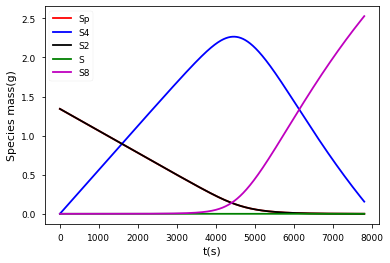

In [227]:
voltage = solution["Cell voltage [V]"].entries
mass_Sp = solution["Mass of precipitated S(2-) [g]"].entries
mass_S4 = solution["Mass of dissolved S4(2-) [g]"].entries
mass_S2 = solution["Mass of dissolved S2(2-) [g]"].entries
mass_S = solution["Mass of dissolved S(2-) [g]"].entries
mass_S8 = solution["Mass of dissolved S8 [g]"].entries
i_L_sol = solution["Current contribution L [A]"].entries
i_H_sol = solution["Current contribution H [A]"].entries

plt.plot(t_eval, mass_Sp, label = "Sp")
plt.plot(t_eval, mass_S4, label = "S4")
plt.plot(t_eval, mass_S2, label = "S2")
plt.plot(t_eval, mass_S, label = "S")
plt.plot(t_eval, mass_S8, label = "S8")
plt.legend();
plt.xlabel('t(s)');
plt.ylabel('Species mass(g)');

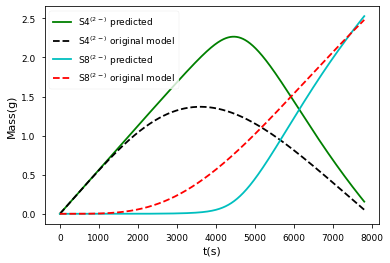

In [228]:
import csv
import pandas as pd

#Graph plotting: https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

data_S4 = pd.read_csv("0D model CSV files/S4_ch_0.5C.csv")
x_S4 = data_S4.mass_S4;
data_S8 = pd.read_csv("0D model CSV files/S8_ch_0.5C.csv")
x_S8 = data_S8.mass_S8;
plt.plot(t_eval, mass_S4, 'g', label = "S4$^{(2-)}$ predicted")
plt.plot(t_eval, x_S4, 'k--', label = "S4$^{(2-)}$ original model")
plt.plot(t_eval, mass_S8, 'c', label = "S8$^{(2-)}$ predicted")
plt.plot(t_eval, x_S8, 'r--', label = "S8$^{(2-)}$ original model")
plt.xlabel('t(s)')
plt.ylabel('Mass(g)')
#plt.title('Mass of dissolved $S4^{(2-)}$ and $S8^{(2-)}$ during discharge')
plt.legend()
#plt.savefig("test.jpg")

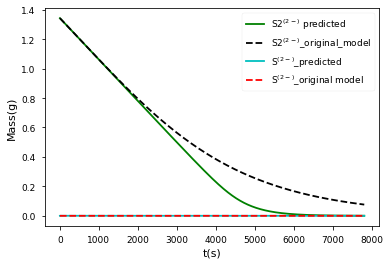

In [229]:
data_S2 = pd.read_csv("0D model CSV files/S2_ch_0.5C.csv")
x_S2 = data_S2.mass_S2;
data_S = pd.read_csv("0D model CSV files/S_ch_0.5C.csv")
x_S = data_S.mass_S;
plt.plot(t_eval, mass_S2, 'g', label = "S2$^{(2-)}$ predicted")
plt.plot(t_eval, x_S2, 'k--', label = "S2$^{(2-)}$_original_model")
plt.plot(t_eval, mass_S, 'c', label = "S$^{(2-)}$_predicted")
plt.plot(t_eval, x_S, 'r--', label = "S$^{(2-)}$_original model")
plt.xlabel('t(s)')
plt.ylabel('Mass(g)')
#plt.title('Mass of dissolved $S2^{(2-)}$ and $S^{(2-)}$ during discharge')
plt.legend()

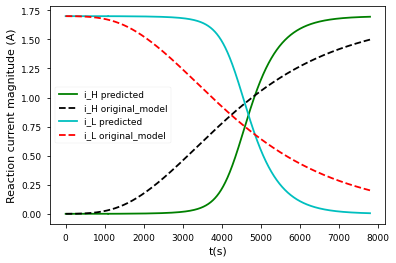

In [230]:
data_iH = pd.read_csv("0D model CSV files/iH_ch_0.5C.csv")
x_iH = data_iH.iH;
x_iH = -x_iH
data_iL = pd.read_csv("0D model CSV files/iL_ch_0.5C.csv")
x_iL = data_iL.iL;
x_iL = -x_iL

plt.plot(t_eval, -i_H_sol, 'g', label = "i_H predicted")
plt.plot(t_eval, x_iH, 'k--', label = "i_H original_model")
plt.plot(t_eval, -i_L_sol, 'c', label = "i_L predicted")
plt.plot(t_eval, x_iL, 'r--', label = "i_L original_model")
plt.xlabel('t(s)')
plt.ylabel('Reaction current magnitude (A)')
#plt.title('Distribution of current contributions for higher and lower plateau reactions during discharge')
plt.legend()

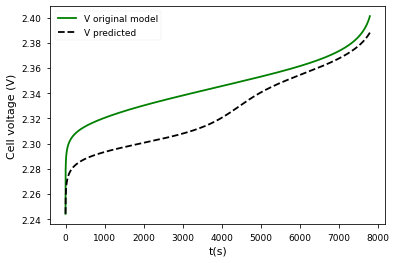

In [231]:
data_V = pd.read_csv("0D model CSV files/V_ch_0.5C.csv")
x_V = data_V.V;

plt.plot(t_eval, x_V, 'g', label = "V original model")
plt.plot(t_eval, voltage, 'k--', label = "V predicted")
plt.xlabel('t(s)')
plt.ylabel('Cell voltage (V)')
#plt.title('Voltage discharge curve')
plt.legend()

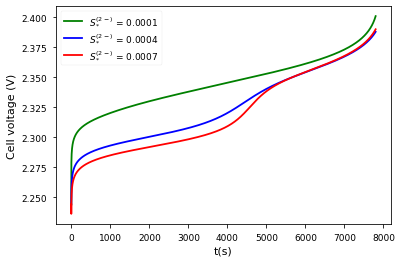

In [235]:
data_V_ksphigh = pd.read_csv("0D model CSV files/V_ch_0.5C_ksp0.0007.csv")
x_V_ksphigh = data_V_ksphigh.V

plt.plot(t_eval, x_V, 'g', label = "$S_*^{(2-)}$ = 0.0001")
plt.plot(t_eval, voltage, 'b', label = "$S_*^{(2-)}$ = 0.0004")
plt.plot(t_eval, x_V_ksphigh, 'r', label = "$S_*^{(2-)}$ = 0.0007")
plt.xlabel('t(s)')
plt.ylabel('Cell voltage (V)')
#plt.title('Voltage discharge curve')
plt.legend()

In [233]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). ECSarXiv. February, 2020. doi:10.1149/osf.io/67ckj.

